In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library

In [ ]:
# colab only

!pip install iterative-stratification
!pip install optuna
!pip install --upgrade category_encoders
!pip install catboost

In [ ]:
# path for MultilabelStratifiedKFold
import sys
sys.path.append('../input/iterativestratification')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

# for checking multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# AutoML framework
import optuna
from optuna.samplers import TPESampler

# Import sklearn classes for model selection, cross validation, and performance evaluation

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import libraries for gradient boosting
from sklearn.ensemble import RandomForestClassifier  # Bagging
from xgboost.sklearn import XGBClassifier            # GBM
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier


# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Load

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/SC_PJ/icr-identify-age-related-conditions (1).zip (Unzipped Files)/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/SC_PJ/icr-identify-age-related-conditions (1).zip (Unzipped Files)/test.csv')
greeks = pd.read_csv('/content/drive/MyDrive/Kaggle/SC_PJ/icr-identify-age-related-conditions (1).zip (Unzipped Files)/greeks.csv')

pd.set_option('display.max_columns', None)

# Preprocessing & Feature Engineering

In [ ]:
# categorical feature LabelEncoding
train['EJ'] = train['EJ'].replace({'A': 0, 'B': 1})
test['EJ']  = test['EJ'].replace({'A': 0, 'B': 1})
target_col = 'Class'

# drop the 'Id' column
X_train = train.drop([f'{target_col}', 'Id'],axis=1).reset_index(drop=True)
y_train = train[f'{target_col}'].reset_index(drop=True)

X_test = test.drop(['Id'],axis=1).reset_index(drop=True)
greeks = greeks.drop(['Id'],axis=1).reset_index(drop=True)

# 결측치 KNNImputer 사용
imp = KNNImputer()
X_train_1=imp.fit_transform(X_train)
X_test_1 = imp.transform(X_test)

tmp1 = pd.DataFrame(columns=X_train.columns, data = X_train_1)
X_train = pd.concat([tmp1], axis=1)

tmp2 = pd.DataFrame(columns=X_test.columns, data = X_test_1)
X_test = pd.concat([tmp2], axis=1)


# 'EJ'만 제외하고 standarscaler 적용
numeric_columns = [_ for _ in X_train.columns if _ not in ['EJ']]

sc = StandardScaler() # MinMaxScaler or StandardScaler or RobustScaler
X_train[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = sc.transform(X_test[numeric_columns])

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

X_train shape :(617, 56) , y_train shape :(617,)
X_test shape :(5, 56)


## Data Imbalance - OverSamping

In [ ]:
greeks.head(3)

,Alpha,Beta,Gamma,Delta,Epsilon
0,B,C,G,D,3/19/2019
1,A,C,M,B,Unknown
2,A,C,M,B,Unknown


In [ ]:
# greeks DataFrame LabelEncoding

greeks['Epsilon'] = 0

cols = greeks.columns

for col in cols:
    le = LabelEncoder()
    greeks[col] = le.fit_transform(greeks[col])
greeks

,Alpha,Beta,Gamma,Delta,Epsilon
0,1,2,4,3,0
1,0,2,6,1,0
2,0,2,6,1,0
3,0,2,6,1,0
4,2,1,3,1,0
...,...,...,...,...,...
612,0,1,6,1,0
613,0,1,6,1,0
614,0,2,6,1,0
615,0,2,6,1,0


In [ ]:
train = pd.concat([X_train, y_train, greeks],axis=1)
train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,-0.405383,0.339209,-0.302886,0.589077,-0.052080,-0.141323,-0.187958,-0.477737,-1.297242,-0.471172,-0.482062,-0.184071,-2.395430,-1.340889,-0.151929,0.617755,0.847190,-0.334913,-0.206823,-0.733141,-0.671125,-0.371319,0.409165,0.388996,-0.122533,-0.176847,-0.287078,-0.523902,-0.166640,0.348860,1.0,-1.023528,-0.387976,-0.167462,-0.350839,0.051544,-0.112922,-2.226608,0.162497,-0.035806,-0.251857,-0.940094,-0.410260,-0.655511,-0.948991,0.531241,-0.814910,1,1,2,4,3,0
1,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,0.048541,-0.575174,-0.410427,-0.899462,-0.154167,-0.141323,-0.294715,-0.776607,-0.768742,-0.380234,0.055912,-0.150931,1.336593,-0.498868,-0.049436,0.704580,0.928108,-0.703485,-0.206823,-0.031113,-0.423071,-0.675043,1.389567,-0.199154,-0.122533,-0.506390,-0.669271,-1.072690,-0.346584,-0.163632,0.0,1.088176,-0.141038,-0.043236,-0.327962,-0.102520,-0.311056,0.084542,-0.458271,-0.060566,0.112170,-1.145070,-0.410260,0.687893,-0.238862,-0.509218,1.304748,0,0,2,6,1,0
2,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,-0.071089,1.456789,-0.556635,1.307838,-0.097236,-0.141323,-0.280350,-0.734334,-0.083354,-0.432487,0.378696,-0.184071,-0.149169,0.141845,-0.695142,-0.389911,0.929115,-0.253473,-0.206823,-1.386753,-0.312920,-1.039165,0.209516,-0.056781,-0.122533,0.578520,-0.203224,2.470916,-0.132589,0.039058,1.0,1.088176,-0.387976,-0.163455,0.924601,0.028054,-0.173811,0.517060,0.198341,-0.051023,0.595806,1.637944,-0.299210,-0.051850,-0.351743,-0.424754,-0.807481,0,0,2,6,1,0
3,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,-0.391109,0.644004,0.032419,-0.939432,-0.073537,-0.141323,-0.389772,0.108090,-0.040595,-0.655850,-0.105480,-0.001802,-0.377933,0.243409,-1.228106,-0.385077,-0.181774,-0.646618,-0.206823,-0.660517,-0.083097,-0.822960,-0.250951,0.094615,-0.122533,1.415032,-0.272247,0.363960,7.804389,0.167593,1.0,-1.002074,-0.387976,-0.096939,-0.073095,0.014748,0.058201,1.617160,0.060037,-0.060566,-0.106246,-0.219883,-0.342195,-0.650833,0.858232,1.101332,-0.811468,0,0,2,6,1,0
4,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,0.125327,0.745602,0.507084,0.556808,0.641647,-0.141323,0.032566,-0.580232,-0.341605,1.423044,-0.347569,-0.184071,-0.174795,-0.300995,-1.033369,0.495398,1.082256,-0.635372,-0.206823,-1.410960,-0.570275,-1.486749,-0.043656,-0.072838,-0.122533,-0.957029,-0.277951,0.207163,-0.183137,-0.076294,1.0,1.088176,-0.191049,-0.046107,-0.255804,-0.041041,0.520331,1.212850,0.236981,0.896815,-0.231056,-0.432313,0.099920,-0.318309,1.409422,-0.395228,-0.817211,1,2,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,-0.699975,-0.161828,0.040232,-0.422762,0.275215,-0.802577,0.040875,-0.464891,-0.080610,-0.395082,-0.067183,-0.345104,-0.764233,-0.112644,-0.141323,-0.224856,0.007070,-0.680762,-0.476442,-1.127630,-0.117791,-0.156643,0.187927,-0.582400,-1.375895,-1.385756,-0.144794,-0.206823,0.695122,0.348842,-0.137385,0.197622,-0.199154,0.333185,0.338063,-0.170709,-0.831615,-0.691066,-0.163632,0.0,-0.463806,-0.387976,-0.008452,-0.252141,-0.102520,0.605929,-0.079062,-0.458271,-0.045332,-0.272659,-1.177680,0.593022,-0.340465,-0.694915,0.513497,1.304748,0,0,1,6,1,0
613,-0.088253,0.852755,-0.261669,0.108831,0.556117,0.170319,-0.082686,0.473063,-0.065661,0.100596,1.659985,0.295392,2.660107,-0.094215,-0.141323,-0.095392,0.314578,-0.097351,-0.336167,0.513189,-0.184071,0.066781,0.170141,1.4

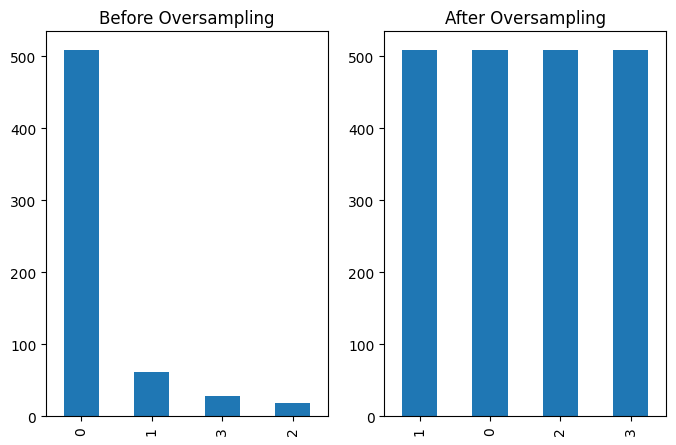

In [ ]:
# data imbalance

train = pd.concat([X_train, y_train, greeks],axis=1)

# greeks 테이블의 'Alpha' feature 기준
# oversampling 'SMOTE' 라이브러리 사용
X_over1, y_over1 = SMOTE(random_state=42).fit_resample(train, greeks.Alpha)

# 오버샘플링 전후 shape check
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.title("Before Oversampling")
greeks['Alpha'].value_counts().plot(kind = 'bar')
plt.subplot(1, 2, 2)
plt.title("After Oversampling")
y_over1.value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
print(f'오버샘플링 전 shape 체크: ', greeks.Alpha.shape)
print(f'오버샘플링 후 shape 체크: ', y_over1.shape)

오버샘플링 전 shape 체크:  (617,)
오버샘플링 후 shape 체크:  (2036,)


In [ ]:
ov_train = pd.concat([X_over1, y_over1],axis=1)
X_train = ov_train.iloc[:,:-7]
greeks = ov_train.iloc[:,-6:-1]
y_train = ov_train.iloc[:,-7:-6]

In [ ]:
X_train.head(3)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,-0.405383,0.339209,-0.302886,0.589077,-0.052080,-0.141323,-0.187958,-0.477737,-1.297242,-0.471172,-0.482062,-0.184071,-2.395430,-1.340889,-0.151929,0.617755,0.847190,-0.334913,-0.206823,-0.733141,-0.671125,-0.371319,0.409165,0.388996,-0.122533,-0.176847,-0.287078,-0.523902,-0.166640,0.348860,1.0,-1.023528,-0.387976,-0.167462,-0.350839,0.051544,-0.112922,-2.226608,0.162497,-0.035806,-0.251857,-0.940094,-0.41026,-0.655511,-0.948991,0.531241,-0.814910
1,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,0.048541,-0.575174,-0.410427,-0.899462,-0.154167,-0.141323,-0.294715,-0.776607,-0.768742,-0.380234,0.055912,-0.150931,1.336593,-0.498868,-0.049436,0.704580,0.928108,-0.703485,-0.206823,-0.031113,-0.423071,-0.675043,1.389567,-0.199154,-0.122533,-0.506390,-0.669271,-1.072690,-0.346584,-0.163632,0.0,1.088176,-0.141038,-0.043236,-0.327962,-0.102520,-0.311056,0.084542,-0.458271,-0.060566,0.112170,-1.145070,-0.41026,0.687893,-0.238862,-0.509218,1.304748
2,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,-0.071089,1.456789,-0.556635,1.307838,-0.097236,-0.141323,-0.280350,-0.734334,-0.083354,-0.432487,0.378696,-0.184071,-0.149169,0.141845,-0.695142,-0.389911,0.929115,-0.253473,-0.206823,-1.386753,-0.312920,-1.039165,0.209516,-0.056781,-0.122533,0.578520,-0.203224,2.470916,-0.132589,0.039058,1.0,1.088176,-0.387976,-0.163455,0.924601,0.028054,-0.173811,0.517060,0.198341,-0.051023,0.595806,1.637944,-0.29921,-0.051850,-0.351743,-0.424754,-0.807481


In [ ]:
y_train.head(3)

,Class
0,1
1,0
2,0


In [ ]:
greeks.head(3)

,Alpha,Beta,Gamma,Delta,Epsilon
0,1,2,4,3,0
1,0,2,6,1,0
2,0,2,6,1,0


In [ ]:
print(X_train.shape, y_train.shape, greeks.shape)

(2036, 56) (2036, 1) (2036, 5)


# Modeling

## Base Model

In [ ]:
# Optuna & flaml 을 통한 hyperparameter tuning 적용

lgb_clf = LGBMClassifier(n_estimators = 1334, num_leaves=100, min_child_samples = 22, learning_rate=0.042446622277516506, max_bin=10,colsample_bytree=0.9056178902843575, reg_alpha=0.009532984546689516, reg_lambda=1.5059973989907303)
cat_clf = CatBoostClassifier(max_depth=5, n_estimators=252, verbose = False)
hist_clf = HistGradientBoostingClassifier()
rf_clf = RandomForestClassifier(max_depth=15, n_estimators=2723, min_samples_split=5, random_state = 20230801)


## Loss Function

In [ ]:
def balanced_log_loss(y_true, y_pred):
    # 각 class 별로 관측치 수 계산
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # weight 계산
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # 예측 확률 계산
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # log loss 계산
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))

    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)

    return balanced_log_loss/(N_0+N_1)

## Base Model Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):


    # Cross Validation
    # kf = KFold(n_splits=n_folds, shuffle=True, random_state=721)

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=721)

    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
    #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')

        if type(X_train_n) is np.ndarray:
            X_tr = X_train_n[train_index]
            y_tr = y_train_n[train_index]
            X_te = X_train_n[valid_index]
            y_te = y_train_n[valid_index]
        else:
            X_tr = X_train_n.iloc[train_index]
            y_tr = y_train_n.iloc[train_index]
            X_te = X_train_n.iloc[valid_index]
            y_te = y_train_n.iloc[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)

        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)


    # 평가 지표인 balanced_log_loss를 사용해서 모델별 평가
    print(model.__class__.__name__, 'balanced_log_loss: ', balanced_log_loss(y_train_n, train_fold_pred))

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 Meta 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

## model training

In [ ]:
# base model
# stacking of 4 models
lgb_train, lgb_test = get_stacking_base_datasets(lgb_clf, X_train, y_train, X_test, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_clf, X_train, y_train, X_test, 5)
hist_train, hist_test = get_stacking_base_datasets(hist_clf, X_train, y_train, X_test, 5)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 5)

LGBMClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMClassifier balanced_log_loss:  Class    0.534379
dtype: float64
CatBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
CatBoostClassifier balanced_log_loss:  Class    0.848221
dtype: float64
HistGradientBoostingClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
HistGradientBoostingClassifier balanced_log_loss:  Class    0.585273
dtype: float64
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
RandomForestClassifier balanced_log_loss:  Class    0.644648
dtype: float64


## Stacking

In [ ]:
# Final Stacking Model

# Optuna & flaml 을 통한 hyperparameter tuning 적용
lgb_final = LGBMClassifier(n_estimators = 1334, num_leaves=100, min_child_samples = 22, learning_rate=0.042446622277516506, max_bin=10,colsample_bytree=0.9056178902843575, reg_alpha=0.009532984546689516, reg_lambda=1.5059973989907303)

In [ ]:
# Meta 학습 및 테스트 반환을 위해 numpy 배열 초기화
Stack_final_X_train = np.zeros((2036, 4))
Stack_final_X_test = np.zeros((5, 4))

# Meta 학습 데이터 생성 (Stacking)
Stack_final_X_train = np.concatenate((lgb_train, cat_train, hist_train,rf_train), axis=1)

# Meta 테스트 데이터 생성 (Stacking)
Stack_final_X_test = np.concatenate((lgb_test, cat_test, hist_test, rf_test), axis=1)

print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (2036, 56) 원본 테스트 피처 Shape: (5, 56)
스태킹 학습 피처 데이터 Shape: (2036, 4) 스태킹 테스트 피처 데이터 Shape: (5, 4)


In [ ]:
# 최종 모델 평가
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(Stack_final_X_train, y_train, test_size = 0.3, stratify = y_train, random_state = 721)

lgb_final.fit(X_tr, y_tr)
pred = lgb_final.predict(X_val).reshape(-1,1)
print('balanced_log_loss: ', balanced_log_loss(y_val, pred))


balanced_log_loss:  Class    0.338992
dtype: float64


In [ ]:
lgb_final.fit(Stack_final_X_train, y_train)
stack_final = lgb_final.predict_proba(Stack_final_X_test)

stack_final

array([[9.99944312e-01, 5.56884406e-05],
       [9.99944312e-01, 5.56884406e-05],
       [9.99944312e-01, 5.56884406e-05],
       [9.99944312e-01, 5.56884406e-05],
       [9.99944312e-01, 5.56884406e-05]])

# Submission

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Kaggle/SC_PJ/icr-identify-age-related-conditions (1).zip (Unzipped Files)/sample_submission.csv')
sub[['class_0', 'class_1']] = stack_final
sub.to_csv('submission.csv',index=False)
sub

,Id,class_0,class_1
0,00eed32682bb,0.999945,0.000055
1,010ebe33f668,0.999945,0.000055
2,02fa521e1838,0.999945,0.000055
3,040e15f562a2,0.999945,0.000055
4,046e85c7cc7f,0.999945,0.000055
